# HW2

### Installing and importing packages

In [ ]:
!apt-get install net-tools # To see my interface
!apt-get install tcpdump # To capture packages
!apt-get install curl # To create traffic to websites
!apt-get install tshark # To deal with captures

In [ ]:
!pip install pyshark # To deal with captures
!pip install nest_asyncio # Helpful while reading pcap files

In [2]:
import pyshark # To deal with captures
import pandas as pd # To get benefits of data frames

# Helpful while reading/writing files
import nest_asyncio
from datetime import datetime # To deal with timestamps
import os
from os import listdir
from os.path import isfile, join
import zipfile

# To train KNN and plot the results
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from joblib import dump, load


### Preparing environment

Since the location of the Colab VM might affect the flow features, I check the location of the VM, while creating the next dataset I make sure that I am in the same location.

In [107]:
import urllib
import json
def get_information(ip):
        info = json.loads(urllib.request.urlopen('http://ip-api.com/json/'+ip).read())
        country = info['country']
        city = info['city']
        latitude = info['lat']
        longitude = info['lon']
        return country, city, latitude, longitude

api='https://api.ipify.org'
my_ip = urllib.request.urlopen(api).read().decode('UTF-8')
my_country, my_city, my_latitude, my_longitude =  get_information(my_ip)
my_ip, my_country, my_city, my_latitude, my_longitude
# VM location for first capture : ('34.106.175.237', 'United States', 'Salt Lake City', 40.7607, -111.891)

('34.106.175.237', 'United States', 'Salt Lake City', 40.7607, -111.891)

With ifconfig, we can understand that eth0 is the interface that Colab VM connects to internet, and 172.28.0.12 is the IP address

In [126]:
!ifconfig

eth0: flags=4163<UP,BROADCAST,RUNNING,MULTICAST>  mtu 1500
        inet 172.28.0.12  netmask 255.255.0.0  broadcast 172.28.255.255
        ether 02:42:ac:1c:00:0c  txqueuelen 0  (Ethernet)
        RX packets 124539  bytes 348754760 (348.7 MB)
        RX errors 0  dropped 0  overruns 0  frame 0
        TX packets 115698  bytes 508745124 (508.7 MB)
        TX errors 0  dropped 0 overruns 0  carrier 0  collisions 0

lo: flags=73<UP,LOOPBACK,RUNNING>  mtu 65536
        inet 127.0.0.1  netmask 255.0.0.0
        loop  txqueuelen 1000  (Local Loopback)
        RX packets 279365  bytes 575461360 (575.4 MB)
        RX errors 0  dropped 0  overruns 0  frame 0
        TX packets 279365  bytes 575461360 (575.4 MB)
        TX errors 0  dropped 0 overruns 0  carrier 0  collisions 0



In [4]:
! mkdir captures # In case there is no directory

### Capturing Packages

To capture the packages, a bash script is used.

Inside the bash script, it takes at least 4 arguments. First argument is output directory, the second argument is output file prefix, the third argument is the number of curls, and the other arguments are the URLs that we want to examine traffic.

```
#!/bin/bash

# Checking if all arguments are provided
if [ "$#" -lt 4 ]; then
    echo "Usage: $0 <output_directory> <output_file_prefix> <num_curls> <url1> [<url2> ... <urlN>]"
    exit 1
fi

output_directory="$1"
output_file_prefix="$2"
num_curls="$3"
shift 3  # Removing the first three arguments, leaving only the URLs


```
After that, There is a python function to get the IP address of the host inside the bash sciprt.

```
# Function to get IP address from URL
get_ip_address() {
    python3 - <<END
import socket
from urllib.parse import urlparse

def get_ip_address(url):
    try:
        # Parse the URL to extract the hostname
        parsed_url = urlparse(url)
        hostname = parsed_url.hostname

        # Get the IP address
        ip_address = socket.gethostbyname(hostname)
        return ip_address
    except socket.gaierror:
        return None

print(get_ip_address("$1"))
END
}

```
Then capture_traffic function captures the traffic for a given URL. The function starts with setting the output file, and host ip.

```
capture_traffic() {
    url="$1"
    output_file="$output_directory/$output_file_prefix-$(echo "$url" | tr -dc '[:alnum:]\n\r' | tr '[:upper:]' '[:lower:]')"
    
    # Get host IP
    host_ip=$(get_ip_address "$url")
```
To capture TCP packages from the host are captured with this tcpdump command and saved as a pcap file. TLS, HTTP and HTTPS use TCP. UDP is captured for DNS Queries. Therefore, those traffic with the related URL is captured.

```
tcpdump -i eth0 -nn -X "(tcp and host $host_ip) or udp" -w "$output_file.pcap" &``
    # Waiting for tcpdump to start
    sleep 2
```
Then we curl num_curls times for the URL to generate traffic, for this case it is 10
```
    for i in $(seq "$num_curls"); do
        curl -s "$url" > /dev/null
        sleep 1
    done
```
This function is called for the each URL, given in the bash command
```

# Iterate over each URL and capture traffic
for url in "$@"; do
    capture_traffic "$url"
done

```



The bash command is applied to capture packages

In [108]:
! bash capture.sh captures 10 capture \
    https://www.indiatimes.com \
    https://www.washingtonpost.com \
    https://www.ndtv.com \
    https://www.cnbc.com \
    https://www.timesofindia.com \
    https://www.express.co.uk \
    https://www.rt.com \
    https://www.news18.com \
    https://www.nypost.com \
    https://www.abc.net.au


tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
1636 packets captured2732 packets captured

1636 packets received by filter2732 packets received by filter

0 packets dropped by kernel0 pac

The next cell is just to create a zip file of the captures in order to be downloaded or transferred

In [109]:
directory_to_zip = "/content/captures"
zip_file_name = "captures_tcp_udp.zip"

# Create a zipfile object in write mode
with zipfile.ZipFile(zip_file_name, 'w') as zipf:
    # Iterate over all the files and folders within the directory
    for root, dirs, files in os.walk(directory_to_zip):
        for file in files:
            # Construct the full path of the file
            file_path = os.path.join(root, file)
            # Add the file to the zip
            zipf.write(file_path, os.path.relpath(file_path, directory_to_zip))

### Processing PCAP files and identifying flows

In the next cell, We first read the pcap files which includes the captures that were saved with tcpdump.

The aim is creating a good dataset for identifying flows. Therefore, we create tuples for source and destination IP addresses and ports to identify flows. We also Then the flows are saved as a dataframe.


In [25]:
nest_asyncio.apply()

# Directory containing the pcap files
directory = 'captures'

# Initializing CONVERSATIONS dictionary
CONVERSATIONS = {'ip.src': [], 'ip.dst': [], 'tcp.srcport': [], 'tcp.dstport': [],
                 'udp.srcport': [], 'udp.dstport': [],
                 'bytes': [], 'packets': [], 'start': [], 'duration': [],
                 'label': [], 'ip.proto': [], 'ip.len': [], 'frame.time': []}

# Iterating over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".pcap"):
        filepath = os.path.join(directory, filename)

        # Extracting label from filename, we will need this labels for KNN
        label = filename.split('-')[-1].split('.')[0].replace('httpswww', '').replace('com', '')

        # Reading the pcap file using pyshark
        cap = pyshark.FileCapture(filepath)

        # Iterate over each packet in the pcap file
        for packet in cap:
          # Mutual features for both TCP and UDP packages
            address_a = packet.ip.src
            address_b = packet.ip.dst
            packet_bytes = packet.length
            packet_timestamp = packet.sniff_time
            protocol = packet.ip.proto
            ip_len = packet.ip.len
            frame_time = packet.sniff_time

            # Adding the source and destination ports for TCP and UDP
            if 'tcp' in packet:
                tcp_srcport = packet.tcp.srcport
                tcp_dstport = packet.tcp.dstport
            else:
                tcp_srcport = None
                tcp_dstport = None

            if ('udp' in packet) and ('dns' in packet):
                udp_srcport = packet.udp.srcport
                udp_dstport = packet.udp.dstport
            else:
                udp_srcport = None
                udp_dstport = None

            # Creating tuples and hash them to identify flows
            d_a = tuple([address_a, address_b, tcp_srcport, tcp_dstport])
            entry_a = hash(d_a)

            d_b = tuple([address_a, address_b, tcp_srcport, tcp_dstport])
            entry_b = hash(d_b)

            if entry_a in CONVERSATIONS['start']:
                loc = CONVERSATIONS['start'].index(entry_a)
            elif entry_b in CONVERSATIONS['start']:
                loc = CONVERSATIONS['start'].index(entry_b)
            else:
                CONVERSATIONS['ip.src'].append(address_a)
                CONVERSATIONS['ip.dst'].append(address_b)
                CONVERSATIONS['tcp.srcport'].append(tcp_srcport)
                CONVERSATIONS['tcp.dstport'].append(tcp_dstport)
                CONVERSATIONS['udp.srcport'].append(udp_srcport)
                CONVERSATIONS['udp.dstport'].append(udp_dstport)
                CONVERSATIONS['bytes'].append(int(packet_bytes))
                CONVERSATIONS['start'].append(packet_timestamp)
                CONVERSATIONS['packets'].append(1)
                CONVERSATIONS['duration'].append(0)
                CONVERSATIONS['label'].append(label)
                CONVERSATIONS['ip.proto'].append(protocol)
                CONVERSATIONS['ip.len'].append(ip_len)
                CONVERSATIONS['frame.time'].append(frame_time)
                continue  # Move to the next packet

            CONVERSATIONS['bytes'][loc] += int(packet_bytes)
            CONVERSATIONS['packets'][loc] += 1
            CONVERSATIONS['duration'][loc] = (packet_timestamp - CONVERSATIONS['start'][loc]).total_seconds()
            CONVERSATIONS['ip.proto'][loc] = protocol
            CONVERSATIONS['ip.len'][loc] = ip_len
            CONVERSATIONS['frame.time'][loc] = frame_time

# Creating DataFrame from CONVERSATIONS dictionary
df = pd.DataFrame(CONVERSATIONS)

In [26]:
display(df)

,ip.src,ip.dst,tcp.srcport,tcp.dstport,udp.srcport,udp.dstport,bytes,packets,start,duration,label,ip.proto,ip.len,frame.time
0,172.28.0.12,169.254.169.254,None,None,47337,53,74,1,2024-03-26 03:14:46.368447,0,nypost,17,60,2024-03-26 03:14:46.368447
1,172.28.0.12,169.254.169.254,None,None,56721,53,74,1,2024-03-26 03:14:46.368455,0,nypost,17,60,2024-03-26 03:14:46.368455
2,169.254.169.254,172.28.0.12,None,None,53,56721,90,1,2024-03-26 03:14:46.369115,0,nypost,17,76,2024-03-26 03:14:46.369115
3,169.254.169.254,172.28.0.12,None,None,53,47337,158,1,2024-03-26 03:14:46.385475,0,nypost,17,144,2024-03-26 03:14:46.385475
4,172.28.0.12,192.0.66.32,45550,443,None,None,74,1,2024-03-26 03:14:46.385805,0,nypost,6,60,2024-03-26 03:14:46.385805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19066,169.254.169.254,172.28.0.12,None,None,53,53309,163,1,2024-03-26 03:15:10.259794,0,washingtonpost,17,149,2024-03-26 03:15:10.259794
19067,172.28.0.12,169.254.169.254,None,None,43714,53,74,1,2024-03-26 03:15:11.583857,0,washingtonpost,17,60,2024-03-26 03:15:11.583857
19068,172.28.0.12,169.254.169.254,None,None,53045,53,74,1,2024-03-26 03:15:11.584052,0,washingtonpost,17,60,2024-03-26 03:15:11.584052
19069,169.254.169.254,172.28.0.12,None,None,53,43714,208,1,2024-03-26 03:15:11.584522,0,washingtonpost,17,194,2024-03-26 03:15:11.584522


We can see that 16781 TCP packets and 2290 UDP (DNS) packets were captured

In [27]:
# Calculate the number of TCP packets
tcp_packets = df[df['ip.proto'] == '6'].shape[0]
# Calculate the number of UDP packets
udp_packets = df[df['ip.proto'] == '17'].shape[0]
# Calculate the total number of packets
total_packets = df.shape[0]

# Print the total number of TCP and UDP packets
print(f"Number of TCP packets: {tcp_packets}")
print(f"Number of UDP packets: {udp_packets}")
print(f"Total number of packets: {total_packets}")


Number of TCP packets: 16781
Number of UDP packets: 2290
Total number of packets: 19071


We save them into data directory

In [28]:
! mkdir data
df.to_csv('data/df_flows_tcp_udp.csv', index=False)

mkdir: data: File exists


### Extracting Biflow Feauters

I successfully extracted biflow features from each capture, encompassing both uplink and downlink traffic. The following features were obtained:

Number of Packets (Uplink/Downlink): I meticulously calculated the number of packets for both uplink and downlink traffic in each biflow.

Total Bytes (Uplink/Downlink): Additionally, I computed the total number of bytes transmitted in both the uplink and downlink directions for every biflow.

Packet Size Statistics (Min/Max/Mean/Std) - Uplink/Downlink: I analyzed the packet sizes in each biflow, determining key statistical metrics such as the minimum, maximum, mean, and standard deviation of packet sizes for both uplink and downlink traffic.

Interarrival Time (IAT) Statistics (Min/Max/Mean/Std) - Uplink/Downlink: Furthermore, I examined the interarrival times between packets within each biflow, extracting essential statistical measures including the minimum, maximum, mean, and standard deviation of interarrival times for both uplink and downlink traffic.

By fulfilling these requirements, I have successfully gathered comprehensive biflow features that provide valuable insights into the network traffic dynamics, facilitating further analysis and interpretation.

In the next cell the function for exctracting features is defined

In [33]:
def extract_features(flow,df_flow):
  #compute flow features:
  flow_features = {}
  if(flow[0].split('.')[0]=='172'):
    flow_features['direction'] = 'uplink'
  else:
    flow_features['direction'] = 'downlink'

  flow_features['num_packets'] = len(df_flow);
  pkt_sizes = df_flow['ip.len'].astype(float)
  flow_features['total_bytes'] = pkt_sizes.sum()
  flow_features['min_pkt_size'] = pkt_sizes.min()
  flow_features['max_pkt_size'] = pkt_sizes.max()
  flow_features['mean_pkt_size'] = pkt_sizes.mean()
  flow_features['std_pkt_size'] = pkt_sizes.std()
  iat = pd.to_datetime(df_flow['frame.time']).diff(1).dt.total_seconds().iloc[1:] #
  flow_features['min_iat'] = iat.min()
  flow_features['max_iat'] = iat.max()
  flow_features['mean_iat'] = iat.mean()
  flow_features['std_iat'] = iat.std()
  flow_features['dur'] = iat.sum()
  flow_features['dport'] = flow[3]
  flow_features['sport'] = flow[2]
  return flow_features

df_udp = df[df["ip.proto"]=='17']
df_tcp = df[df["ip.proto"]=='6']

df_flows_udp = df_udp.groupby(["ip.src","ip.dst","udp.srcport","udp.dstport"])
df_flows_tcp = df_tcp.groupby(["ip.src","ip.dst","tcp.srcport","tcp.dstport"])

for flow,df_flow in df_flows_tcp: #flow is a tuple representing the flow, df_flow is the dataframe with all packets of the flow
  flow_features_tcp = extract_features(flow,df_flow)

for flow,df_flow in df_flows_udp: #flow is a tuple representing the flow, df_flow is the dataframe with all packets of the flow
  flow_features_udp = extract_features(flow,df_flow)




In the next cell, we use extract_feature() function to get biflow features. First we read the data that were prepared from the previous cell. We extract the features for TCP and UDP packages separately, then we save into csv files.

In [34]:
path = 'data/'
tcpdumpfiles = [f for f in listdir(path) if isfile(join(path, f))]
apps = np.unique([f.split('_')[0] for f in tcpdumpfiles])
print(apps, len(apps), len(tcpdumpfiles))

dataset_tcp = pd.DataFrame()
for f in tcpdumpfiles:
  print('Processing file  ', f)
  df = pd.read_csv(join(path,f))
  df_tcp = df[df["ip.proto"]==6]
  df_flows_tcp = df_tcp.groupby(["ip.src","ip.dst","tcp.srcport","tcp.dstport"])
  for flow,df_flow in df_flows_tcp: #flow is a tuple representing the flow, df_flow is the dataframe with all packets of the flow
    flow_features = extract_features(flow,df_flow)
    flow_features['app'] = df_flow['label'].iloc[0] ;
    #if(flow_features['direction']=='downlink'):
    flow_features_df = pd.DataFrame([flow_features])
    dataset_tcp = pd.concat([dataset_tcp, flow_features_df], ignore_index=True)

path = 'data/'
tcpdumpfiles = [f for f in listdir(path) if isfile(join(path, f))]
apps = np.unique([f.split('_')[0] for f in tcpdumpfiles])
print(apps, len(apps), len(tcpdumpfiles))

dataset_udp = pd.DataFrame()
for f in tcpdumpfiles:
  print('Processing file  ', f)
  df = pd.read_csv(join(path,f))
  df_udp = df[df["ip.proto"]==17]
  df_flows_udp = df_udp.groupby(["ip.src","ip.dst","udp.srcport","udp.dstport"])
  for flow,df_flow in df_flows_udp: #flow is a tuple representing the flow, df_flow is the dataframe with all packets of the flow
    flow_features = extract_features(flow,df_flow)
    flow_features['app'] = df_flow['label'].iloc[0] ;
    #if(flow_features['direction']=='downlink'):
    flow_features_df = pd.DataFrame([flow_features])
    dataset_udp = pd.concat([dataset_udp, flow_features_df], ignore_index=True)

dataset_tcp.to_csv('traffic_classification_tcp_dataset.csv', index=False)
dataset_udp.to_csv('traffic_classification_udp_dataset.csv', index=False)


['df'] 1 1
Processing file   df_flows_tcp_udp.csv
['df'] 1 1
Processing file   df_flows_tcp_udp.csv


We can see that there are 192 TCP flows and 416 UDP flows are in the dataset. 10 curl for 10 websites created 96 TCP downlink and uplink flow, a curl approximately creates a downlink and a uplink flow, which is expected. I can conclude that 4 curl were unsuccesful, not able to create flow.

In [35]:
# Calculate the number of downlink TCP packets
downlink_tcp_packets = dataset_tcp[dataset_tcp['direction'] == 'downlink'].shape[0]
# Calculate the number of uplink TCP packets
uplink_tcp_packets = dataset_tcp[dataset_tcp['direction'] == 'uplink'].shape[0]
# Print the total number of downlink and uplink TCP packets
print(f"Number of downlink TCP packets: {downlink_tcp_packets}")
print(f"Number of uplink TCP packets: {uplink_tcp_packets}")
display(dataset_tcp)

Number of downlink TCP packets: 96
Number of uplink TCP packets: 96


,direction,num_packets,total_bytes,min_pkt_size,max_pkt_size,mean_pkt_size,std_pkt_size,min_iat,max_iat,mean_iat,std_iat,dur,dport,sport,app
0,downlink,11,7480.0,52.0,2948.0,680.000000,901.783455,0.000001,0.077579,0.016327,0.024660,0.163265,39584.0,443.0,timesofindia
1,downlink,11,7479.0,52.0,2948.0,679.909091,901.835179,0.000001,0.076502,0.017251,0.025470,0.172513,39596.0,443.0,timesofindia
2,downlink,12,7542.0,52.0,2948.0,628.500000,878.098721,0.000001,0.077155,0.019675,0.028031,0.216430,39610.0,443.0,timesofindia
3,downlink,13,7595.0,52.0,2948.0,584.230769,855.748907,0.000001,0.078819,0.017350,0.028382,0.208201,48746.0,443.0,timesofindia
4,downlink,14,7646.0,52.0,2948.0,546.142857,834.421850,0.000001,0.077045,0.018185,0.026285,0.236408,48760.0,443.0,timesofindia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,downlink,15,7270.0,52.0,2948.0,484.666667,811.861940,0.000001,0.099825,0.017056,0.030193,0.238790,56336.0,443.0,indiatimes
188,downlink,15,7270.0,52.0,2948.0,484.666667,811.861940,0.000001,0.101230,0.017518,0.030601,0.245254,56342.0,443.0,indiatimes
189,downlink,15,7270.0,52.0,2948.0,484.666667,811.861940,0.000001,0.100138,0.017277,0.030476,0.241874,56354.0,443.0,indiatimes
190,downlink,14,7218.0,52.0,2948.0,515.571429,833.302301,0.000002,0.099307,0.022189,0.031484,0.288455,56364.0,443.0,indiatimes


In [36]:
# Calculate the number of downlink UDP packets
downlink_udp_packets = dataset_udp[dataset_udp['direction'] == 'downlink'].shape[0]
# Calculate the number of uplink UDP packets
uplink_udp_packets = dataset_udp[dataset_udp['direction'] == 'uplink'].shape[0]
# Print the total number of downlink and uplink UDP packets
print(f"Number of downlink UDP packets: {downlink_udp_packets}")
print(f"Number of uplink UDP packets: {uplink_udp_packets}")
dataset_udp

Number of downlink UDP packets: 208
Number of uplink UDP packets: 208


,direction,num_packets,total_bytes,min_pkt_size,max_pkt_size,mean_pkt_size,std_pkt_size,min_iat,max_iat,mean_iat,std_iat,dur,dport,sport,app
0,downlink,8,608.0,76.0,76.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0,32906.0,53.0,expresscouk
1,downlink,4,764.0,191.0,191.0,191.0,0.0,0.0,0.0,0.0,0.0,0.0,33005.0,53.0,indiatimes
2,downlink,2,296.0,148.0,148.0,148.0,0.0,0.0,0.0,0.0,NaN,0.0,33159.0,53.0,indiatimes
3,downlink,2,296.0,148.0,148.0,148.0,0.0,0.0,0.0,0.0,NaN,0.0,33236.0,53.0,indiatimes
4,downlink,5,1025.0,205.0,205.0,205.0,0.0,0.0,0.0,0.0,0.0,0.0,33461.0,53.0,indiatimes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,uplink,1,64.0,64.0,64.0,64.0,NaN,NaN,NaN,NaN,NaN,0.0,53.0,60506.0,indiatimes
412,uplink,2,136.0,68.0,68.0,68.0,0.0,0.0,0.0,0.0,NaN,0.0,53.0,60562.0,indiatimes
413,uplink,7,392.0,56.0,56.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,60723.0,expresscouk
414,uplink,3,174.0,58.0,58.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,60756.0,indiatimes


### Building KNN

At the beginning, I started by preparing the data. I loaded TCP and UDP traffic from the dataset, and dropped unnecessary columns like 'direction', 'sport', and 'dport'. For UDP traffic, I also dropped the rows where both source and destination ports are not 53, which is the DNS port. After cleaning the data, I concatenated the TCP and UDP datasets into one. The 'app' column is separated from the dataset as it will be used as the target variable for the model.

Next, the dataset into traininxg and testing sets using the train_test_split function as (70%) and test (30%) set. For each K value from 1 to 10, I created a pipeline that first standardizes the data using StandardScaler and then applies the KNN classifier. It uses cross-validation to evaluate the model's performance and stores the mean accuracy score for each K value.

Then I printed the maximum accuracy and the corresponding K value. I also plotted the accuracy scores against the K values using matplotlib. This helps in visualizing how the model's performance changes with different K values.

After finding the best K value, I trained the KNN model using this value. Then tested the model on the test set and predicts the 'app' values. I printed a classification report that includes precision, recall, f1-score, and support for each class. I also displayed the confusion matrix to visualize the performance of the model. The confusion matrix shows the number of correct and incorrect predictions made by the model for each class.

Finally, I saved the trained KNN model using joblib's dump function. This allows the model to be loaded later for the next dataset.



Max accuracy: 0.9455386893743057
K value: 3


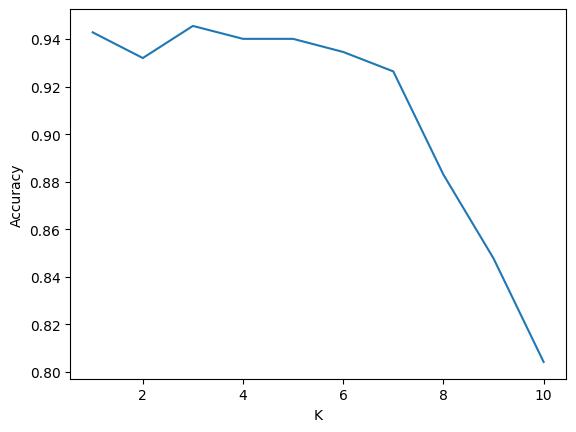

                precision    recall  f1-score   support

      abcnetau       1.00      1.00      1.00         5
          cnbc       1.00      1.00      1.00         5
   expresscouk       0.93      1.00      0.96        41
    indiatimes       0.90      0.95      0.93        39
          ndtv       0.17      0.11      0.13         9
        news18       1.00      1.00      1.00         8
        nypost       0.93      0.86      0.89        29
            rt       1.00      1.00      1.00         7
  timesofindia       0.50      0.50      0.50        10
washingtonpost       1.00      1.00      1.00         5

      accuracy                           0.88       158
     macro avg       0.84      0.84      0.84       158
  weighted avg       0.87      0.88      0.87       158



<Figure size 2000x2000 with 0 Axes>

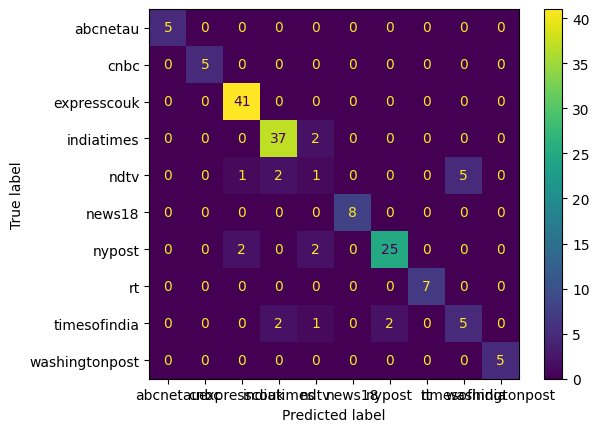

['traffic_classification_knn.joblib']

In [37]:
# Load the TCP and UDP datasets
# Drop the direction, sport, and dport columns and rows with missing values
X_TCP = dataset_tcp.drop(['direction','sport','dport'],axis=1).dropna();
X_UDP = dataset_udp
X_UDP = dataset_udp.drop(['direction','sport','dport'],axis=1).dropna();
X = pd.concat([X_TCP, X_UDP], ignore_index=True)


# Encode the app column
APP = X['app']
X = X.drop(['app'],axis=1)

# Build the KNN model
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, APP, test_size=0.3, random_state=42)

# K values to train the KNN model
k_values = range(1, 11)
scores = []
for k in k_values:
    knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
    score = cross_val_score(knn, X_train, y_train, cv=5)
    scores.append(score.mean())

# Print max accuracy and the K value
print('Max accuracy:', max(scores))
print('K value:', k_values[scores.index(max(scores))])

# Plot the accuracy for K values
plt.plot(k_values, scores)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

# Train the KNN model with the best K value
knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3))
knn.fit(X_train, y_train)

# Test the KNN model
y_pred = knn.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# Print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()
plt.show()

# Save the KNN model
dump(knn, 'traffic_classification_knn.joblib')


# Testing with other dataset

After many trials, I will luckily be able to find the same Colab VM location.

In [1]:
import urllib
import json
def get_information(ip):
        info = json.loads(urllib.request.urlopen('http://ip-api.com/json/'+ip).read())
        country = info['country']
        city = info['city']
        latitude = info['lat']
        longitude = info['lon']
        return country, city, latitude, longitude

api='https://api.ipify.org'
my_ip = urllib.request.urlopen(api).read().decode('UTF-8')
my_country, my_city, my_latitude, my_longitude =  get_information(my_ip)
my_ip, my_country, my_city, my_latitude, my_longitude
# VM location for first capture : ('34.106.175.237', 'United States', 'Salt Lake City', 40.7607, -111.891)

('34.106.204.16', 'United States', 'Salt Lake City', 40.7607, -111.891)

In this time, we run the script with number of curls equals to 3


In [2]:
! mkdir captures_test # In case there is no directory

In [7]:
! bash capture_3.sh captures_test 3 capture_test \
    https://www.indiatimes.com \
    https://www.washingtonpost.com \
    https://www.ndtv.com \
    https://www.cnbc.com \
    https://www.timesofindia.com \
    https://www.express.co.uk \
    https://www.rt.com \
    https://www.news18.com \
    https://www.nypost.com \
    https://www.abc.net.au


tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
559 packets captured
559 packets received by filter
0 packets dropped by kernel
102 packets captured
102 packets received by filter
0 packet

Next cell is to save captures as a zip file to transfer and store data

In [9]:
directory_to_zip = "/content/captures_test"
zip_file_name = "captures_tcp_udp_3.zip"

# Create a zipfile object in write mode
with zipfile.ZipFile(zip_file_name, 'w') as zipf:
    # Iterate over all the files and folders within the directory
    for root, dirs, files in os.walk(directory_to_zip):
        for file in files:
            # Construct the full path of the file
            file_path = os.path.join(root, file)
            # Add the file to the zip
            zipf.write(file_path, os.path.relpath(file_path, directory_to_zip))

### Same Packet Processing with The Previous Part

In [51]:
nest_asyncio.apply()

# Directory containing the pcap files
directory = 'captures_test'

# Initializing CONVERSATIONS dictionary
CONVERSATIONS = {'ip.src': [], 'ip.dst': [], 'tcp.srcport': [], 'tcp.dstport': [],
                 'udp.srcport': [], 'udp.dstport': [],
                 'bytes': [], 'packets': [], 'start': [], 'duration': [],
                 'label': [], 'ip.proto': [], 'ip.len': [], 'frame.time': []}

# Iterating over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".pcap"):
        filepath = os.path.join(directory, filename)

        # Extracting label from filename, we will need this labels for KNN
        label = filename.split('-')[-1].split('.')[0].replace('httpswww', '').replace('com', '')

        # Reading the pcap file using pyshark
        cap = pyshark.FileCapture(filepath)

        # Iterate over each packet in the pcap file
        for packet in cap:
          # Mutual features for both TCP and UDP packages
            address_a = packet.ip.src
            address_b = packet.ip.dst
            packet_bytes = packet.length
            packet_timestamp = packet.sniff_time
            protocol = packet.ip.proto
            ip_len = packet.ip.len
            frame_time = packet.sniff_time

            # Adding the source and destination ports for TCP and UDP
            if 'tcp' in packet:
                tcp_srcport = packet.tcp.srcport
                tcp_dstport = packet.tcp.dstport
            else:
                tcp_srcport = None
                tcp_dstport = None

            if ('udp' in packet) and ('dns' in packet):
                udp_srcport = packet.udp.srcport
                udp_dstport = packet.udp.dstport
            else:
                udp_srcport = None
                udp_dstport = None

            # Creating tuples and hash them to identify flows
            d_a = tuple([address_a, address_b, tcp_srcport, tcp_dstport])
            entry_a = hash(d_a)

            d_b = tuple([address_a, address_b, tcp_srcport, tcp_dstport])
            entry_b = hash(d_b)

            if entry_a in CONVERSATIONS['start']:
                loc = CONVERSATIONS['start'].index(entry_a)
            elif entry_b in CONVERSATIONS['start']:
                loc = CONVERSATIONS['start'].index(entry_b)
            else:
                CONVERSATIONS['ip.src'].append(address_a)
                CONVERSATIONS['ip.dst'].append(address_b)
                CONVERSATIONS['tcp.srcport'].append(tcp_srcport)
                CONVERSATIONS['tcp.dstport'].append(tcp_dstport)
                CONVERSATIONS['udp.srcport'].append(udp_srcport)
                CONVERSATIONS['udp.dstport'].append(udp_dstport)
                CONVERSATIONS['bytes'].append(int(packet_bytes))
                CONVERSATIONS['start'].append(packet_timestamp)
                CONVERSATIONS['packets'].append(1)
                CONVERSATIONS['duration'].append(0)
                CONVERSATIONS['label'].append(label)
                CONVERSATIONS['ip.proto'].append(protocol)
                CONVERSATIONS['ip.len'].append(ip_len)
                CONVERSATIONS['frame.time'].append(frame_time)
                continue  # Move to the next packet

            CONVERSATIONS['bytes'][loc] += int(packet_bytes)
            CONVERSATIONS['packets'][loc] += 1
            CONVERSATIONS['duration'][loc] = (packet_timestamp - CONVERSATIONS['start'][loc]).total_seconds()
            CONVERSATIONS['ip.proto'][loc] = protocol
            CONVERSATIONS['ip.len'][loc] = ip_len
            CONVERSATIONS['frame.time'][loc] = frame_time

# Creating DataFrame from CONVERSATIONS dictionary
df = pd.DataFrame(CONVERSATIONS)


In [52]:
display(df)

,ip.src,ip.dst,tcp.srcport,tcp.dstport,udp.srcport,udp.dstport,bytes,packets,start,duration,label,ip.proto,ip.len,frame.time
0,172.28.0.12,169.254.169.254,None,None,46798,53,72,1,2024-03-27 01:04:22.312395,0,ndtv,17,58,2024-03-27 01:04:22.312395
1,172.28.0.12,169.254.169.254,None,None,55959,53,72,1,2024-03-27 01:04:22.312717,0,ndtv,17,58,2024-03-27 01:04:22.312717
2,169.254.169.254,172.28.0.12,None,None,53,46798,88,1,2024-03-27 01:04:22.312985,0,ndtv,17,74,2024-03-27 01:04:22.312985
3,169.254.169.254,172.28.0.12,None,None,53,55959,128,1,2024-03-27 01:04:22.356483,0,ndtv,17,114,2024-03-27 01:04:22.356483
4,172.28.0.12,23.60.105.65,45088,443,None,None,74,1,2024-03-27 01:04:22.356997,0,ndtv,6,60,2024-03-27 01:04:22.356997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4997,169.254.169.254,172.28.0.12,None,None,53,48286,208,1,2024-03-27 01:05:11.934669,0,news18,17,194,2024-03-27 01:05:11.934669
4998,172.28.0.12,169.254.169.254,None,None,60244,53,74,1,2024-03-27 01:05:13.304999,0,news18,17,60,2024-03-27 01:05:13.304999
4999,172.28.0.12,169.254.169.254,None,None,45586,53,74,1,2024-03-27 01:05:13.305240,0,news18,17,60,2024-03-27 01:05:13.305240
5000,169.254.169.254,172.28.0.12,None,None,53,60244,208,1,2024-03-27 01:05:13.305725,0,news18,17,194,2024-03-27 01:05:13.305725


In [53]:
! mkdir data3
df.to_csv('data3/df_flows_tcp_udp_3.csv', index=False)

mkdir: data3: File exists


In [54]:
def extract_features(flow,df_flow):
  #compute flow features:
  flow_features = {}
  if(flow[0].split('.')[0]=='172'):
    flow_features['direction'] = 'uplink'
  else:
    flow_features['direction'] = 'downlink'

  flow_features['num_packets'] = len(df_flow);
  pkt_sizes = df_flow['ip.len'].astype(float)
  flow_features['total_bytes'] = pkt_sizes.sum()
  flow_features['min_pkt_size'] = pkt_sizes.min()
  flow_features['max_pkt_size'] = pkt_sizes.max()
  flow_features['mean_pkt_size'] = pkt_sizes.mean()
  flow_features['std_pkt_size'] = pkt_sizes.std()
  iat = pd.to_datetime(df_flow['frame.time']).diff(1).dt.total_seconds().iloc[1:] #
  flow_features['min_iat'] = iat.min()
  flow_features['max_iat'] = iat.max()
  flow_features['mean_iat'] = iat.mean()
  flow_features['std_iat'] = iat.std()
  flow_features['dur'] = iat.sum()
  flow_features['dport'] = flow[3]
  flow_features['sport'] = flow[2]
  return flow_features

df_udp = df[df["ip.proto"]=='17']
df_tcp = df[df["ip.proto"]=='6']

df_flows_udp = df_udp.groupby(["ip.src","ip.dst","udp.srcport","udp.dstport"])
df_flows_tcp = df_tcp.groupby(["ip.src","ip.dst","tcp.srcport","tcp.dstport"])

for flow,df_flow in df_flows_tcp: #flow is a tuple representing the flow, df_flow is the dataframe with all packets of the flow
  flow_features_tcp = extract_features(flow,df_flow)

for flow,df_flow in df_flows_udp: #flow is a tuple representing the flow, df_flow is the dataframe with all packets of the flow
  flow_features_udp = extract_features(flow,df_flow)




In [55]:
path = 'data3/'
tcpdumpfiles = [f for f in listdir(path) if isfile(join(path, f))]
apps = np.unique([f.split('_')[0] for f in tcpdumpfiles])
print(apps, len(apps), len(tcpdumpfiles))

dataset_tcp_3 = pd.DataFrame()
for f in tcpdumpfiles:
  print('Processing file  ', f)
  df = pd.read_csv(join(path,f))
  df_tcp = df[df["ip.proto"]==6]
  df_flows_tcp_3 = df_tcp.groupby(["ip.src","ip.dst","tcp.srcport","tcp.dstport"])
  for flow,df_flow in df_flows_tcp_3: #flow is a tuple representing the flow, df_flow is the dataframe with all packets of the flow
    flow_features = extract_features(flow,df_flow)
    flow_features['app'] = df_flow['label'].iloc[0] ;
    #if(flow_features['direction']=='downlink'):
    flow_features_df = pd.DataFrame([flow_features])
    dataset_tcp_3 = pd.concat([dataset_tcp_3, flow_features_df], ignore_index=True)

path = 'data3/'
tcpdumpfiles = [f for f in listdir(path) if isfile(join(path, f))]
apps = np.unique([f.split('_')[0] for f in tcpdumpfiles])
print(apps, len(apps), len(tcpdumpfiles))

dataset_udp_3 = pd.DataFrame()
for f in tcpdumpfiles:
  print('Processing file  ', f)
  df = pd.read_csv(join(path,f))
  df_udp = df[df["ip.proto"]==17]
  df_flows_udp_3 = df_udp.groupby(["ip.src","ip.dst","udp.srcport","udp.dstport"])
  for flow,df_flow in df_flows_udp_3: #flow is a tuple representing the flow, df_flow is the dataframe with all packets of the flow
    flow_features = extract_features(flow,df_flow)
    flow_features['app'] = df_flow['label'].iloc[0] ;
    #if(flow_features['direction']=='downlink'):
    flow_features_df = pd.DataFrame([flow_features])
    dataset_udp_3 = pd.concat([dataset_udp_3, flow_features_df], ignore_index=True)

dataset_tcp_3.to_csv('traffic_classification_tcp_dataset_3.csv', index=False)
dataset_udp_3.to_csv('traffic_classification_udp_dataset_3.csv', index=False)

['df'] 1 1
Processing file   df_flows_tcp_udp_3.csv
['df'] 1 1
Processing file   df_flows_tcp_udp_3.csv


We can see that there are 58 TCP flows and 138 UDP flows are in the dataset. 3 curl for 10 websites created 29 TCP downlink and uplink flow, a curl approximately creates a downlink and a uplink flow, which is expected. I can conclude that a curl were unsuccesful, not able to create flow.

In [56]:
# Calculate the number of downlink TCP packets
downlink_tcp_packets = dataset_tcp_3[dataset_tcp_3['direction'] == 'downlink'].shape[0]
# Calculate the number of uplink TCP packets
uplink_tcp_packets = dataset_tcp_3[dataset_tcp_3['direction'] == 'uplink'].shape[0]
# Print the total number of downlink and uplink TCP packets
print(f"Number of downlink TCP packets: {downlink_tcp_packets}")
print(f"Number of uplink TCP packets: {uplink_tcp_packets}")

display(dataset_tcp_3)


Number of downlink TCP packets: 29
Number of uplink TCP packets: 29


,direction,num_packets,total_bytes,min_pkt_size,max_pkt_size,mean_pkt_size,std_pkt_size,min_iat,max_iat,mean_iat,std_iat,dur,dport,sport,app
0,uplink,58,3854.0,52.0,569.0,66.448276,68.915960,0.000009,0.282585,0.010962,0.040263,0.624850,443.0,58422.0,expresscouk
1,uplink,60,3958.0,52.0,569.0,65.966667,67.788296,0.000007,0.056896,0.002527,0.007709,0.149085,443.0,58430.0,expresscouk
2,uplink,61,4010.0,52.0,569.0,65.737705,67.244802,0.000007,0.055869,0.002495,0.007521,0.149684,443.0,58444.0,expresscouk
3,uplink,13,1384.0,40.0,557.0,106.461538,137.776761,0.000012,0.054362,0.010125,0.015819,0.121498,443.0,38402.0,nypost
4,uplink,14,1424.0,40.0,557.0,101.714286,133.558071,0.000017,0.057046,0.009200,0.015919,0.119596,443.0,38408.0,nypost
5,uplink,14,1424.0,40.0,557.0,101.714286,133.558071,0.000012,0.054530,0.009064,0.015310,0.117832,443.0,38414.0,nypost
6,uplink,164,9354.0,40.0,569.0,57.036585,41.502441,0.000007,0.093541,0.004366,0.013800,0.711615,443.0,40002.0,cnbc
7,uplink,171,9718.0,40.0,569.0,56.830409,40.651321,0.000006,0.054477,0.002493,0.007717,0.423875,443.0,51806.0,cnbc
8,uplink,172,9770.0,40.0,569.0,56.802326,40.533957,0.000006,0.124265,0.002319,0.010846,0.396538,443.0,51820.0,cnbc
9,uplink,16,1750.0,40.0,569.0,109.375000,128.062940,0.000007,0.060570,0.011826,0.017472,0.177395,443.0,58658.0,indiatimes


In [57]:
# Calculate the number of downlink UDP packets
downlink_udp_packets = dataset_udp_3[dataset_udp_3['direction'] == 'downlink'].shape[0]
# Calculate the number of uplink UDP packets
uplink_udp_packets = dataset_udp_3[dataset_udp_3['direction'] == 'uplink'].shape[0]
# Print the total number of downlink and uplink UDP packets
print(f"Number of downlink UDP packets: {downlink_udp_packets}")
print(f"Number of uplink UDP packets: {uplink_udp_packets}")
display(dataset_udp_3)

Number of downlink UDP packets: 69
Number of uplink UDP packets: 69


,direction,num_packets,total_bytes,min_pkt_size,max_pkt_size,mean_pkt_size,std_pkt_size,min_iat,max_iat,mean_iat,std_iat,dur,dport,sport,app
0,downlink,6,1020.0,170.0,170.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,32880.0,53.0,ndtv
1,downlink,1,165.0,165.0,165.0,165.0,NaN,NaN,NaN,NaN,NaN,0.0,33063.0,53.0,indiatimes
2,downlink,2,296.0,148.0,148.0,148.0,0.0,0.0,0.0,0.0,NaN,0.0,33106.0,53.0,washingtonpost
3,downlink,6,1980.0,330.0,330.0,330.0,0.0,0.0,0.0,0.0,0.0,0.0,33627.0,53.0,ndtv
4,downlink,3,342.0,114.0,114.0,114.0,0.0,0.0,0.0,0.0,0.0,0.0,35587.0,53.0,ndtv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,uplink,7,392.0,56.0,56.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,59819.0,ndtv
134,uplink,9,540.0,60.0,60.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,60099.0,ndtv
135,uplink,10,600.0,60.0,60.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,60244.0,ndtv
136,uplink,7,420.0,60.0,60.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,60782.0,ndtv


### Testing The New Dataset with The Trained Model

Accuracy: 0.17857142857142858
                precision    recall  f1-score   support

      abcnetau       0.60      1.00      0.75         6
          cnbc       0.71      0.83      0.77         6
   expresscouk       0.06      0.50      0.11         6
    indiatimes       0.00      0.00      0.00         6
          ndtv       0.44      0.03      0.06       116
        news18       1.00      0.33      0.50         6
        nypost       0.10      0.50      0.16         6
            rt       0.00      0.00      0.00         6
  timesofindia       0.75      0.50      0.60         6
washingtonpost       1.00      1.00      1.00         4

      accuracy                           0.18       168
     macro avg       0.47      0.47      0.40       168
  weighted avg       0.45      0.18      0.17       168



<Figure size 2000x2000 with 0 Axes>

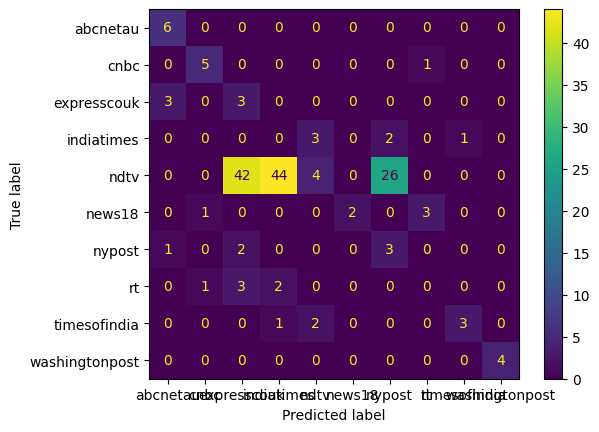

In [60]:
X_TCP = dataset_tcp_3.drop(['direction','sport','dport'],axis=1).dropna();
X_UDP = dataset_udp_3.drop(['direction','sport','dport'],axis=1).dropna();
X_test = pd.concat([X_TCP, X_UDP], ignore_index=True)

# Store the 'app' feature in a separate variable
y_test = X_test['app']

# Remove the 'app' feature from the test data
X_test = X_test.drop('app', axis=1)

# Load the KNN model
knn = load('traffic_classification_knn.joblib')

# Test the KNN model
y_pred = knn.predict(X_test)

# Print the accuracy
print('Accuracy:', knn.score(X_test, y_test))

# Print the classification report
print(classification_report(y_test, y_pred))

# Print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()

### Conclusion
KNN model worked very well for the measurements that were held in the same time in the same Colab VM. However,  I observed that the accuracy is reduced very sharply. One reason could be the overfitting to previous data. Another reason is the websites are news websites. Their content can change drastically, which affects HTTPS traffic. When we look at the confusion matrix, we can see that some websites has very high precision. All the prediction about washingtonpost are correct. CNBC predictions are also satisfying. It is probably due to their content did not change so much. Another reason can be the Colab VM. Although, I did both measurement from the same location, there could be another changes that I cannot detect.

# Trace of Packets

I was able to plot traces, however, not able to made a predictor. I read pcap files as before but  I drop TCP ACKs by continue
````
 if 'tcp' in packet and 'ACK' in packet.tcp.flags:
    continue
````

In [5]:
nest_asyncio.apply()

# Directory containing the pcap files
directory = 'captures'

# Initializing CONVERSATIONS dictionary
CONVERSATIONS = {'ip.src': [], 'ip.dst': [], 'tcp.srcport': [], 'tcp.dstport': [],
                 'bytes': [], 'packets': [], 'start': [], 'duration': [],
                 'label': [], 'ip.proto': [], 'ip.len': [], 'frame.time': []}

# Iterating over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".pcap"):
        filepath = os.path.join(directory, filename)

        # Extracting label from filename, we will need this labels for KNN
        label = filename.split('-')[-1].split('.')[0].replace('httpswww', '').replace('com', '')

        # Reading the pcap file using pyshark
        cap = pyshark.FileCapture(filepath)

        # Iterate over each packet in the pcap file
        for packet in cap:
            if 'tcp' in packet and 'ACK' in packet.tcp.flags:
                continue
            # Mutual features for both TCP and UDP packages
            address_a = packet.ip.src
            address_b = packet.ip.dst
            packet_bytes = packet.length
            packet_timestamp = packet.sniff_time
            protocol = packet.ip.proto
            ip_len = packet.ip.len
            frame_time = packet.sniff_time

            # Adding the source and destination ports for TCP and UDP
            if 'tcp' in packet:
                tcp_srcport = packet.tcp.srcport
                tcp_dstport = packet.tcp.dstport
            else:
                tcp_srcport = None
                tcp_dstport = None

            # Creating tuples and hash them to identify flows
            d_a = tuple([address_a, address_b, tcp_srcport, tcp_dstport])
            entry_a = hash(d_a)

            d_b = tuple([address_a, address_b, tcp_srcport, tcp_dstport])
            entry_b = hash(d_b)

            if entry_a in CONVERSATIONS['start']:
                loc = CONVERSATIONS['start'].index(entry_a)
            elif entry_b in CONVERSATIONS['start']:
                loc = CONVERSATIONS['start'].index(entry_b)
            else:
                CONVERSATIONS['ip.src'].append(address_a)
                CONVERSATIONS['ip.dst'].append(address_b)
                CONVERSATIONS['tcp.srcport'].append(tcp_srcport)
                CONVERSATIONS['tcp.dstport'].append(tcp_dstport)
                CONVERSATIONS['bytes'].append(int(packet_bytes))
                CONVERSATIONS['start'].append(packet_timestamp)
                CONVERSATIONS['packets'].append(1)
                CONVERSATIONS['duration'].append(0)
                CONVERSATIONS['label'].append(label)
                CONVERSATIONS['ip.proto'].append(protocol)
                CONVERSATIONS['ip.len'].append(ip_len)
                CONVERSATIONS['frame.time'].append(frame_time)
                continue  # Move to the next packet

            CONVERSATIONS['bytes'][loc] += int(packet_bytes)
            CONVERSATIONS['packets'][loc] += 1
            CONVERSATIONS['duration'][loc] = (packet_timestamp - CONVERSATIONS['start'][loc]).total_seconds()
            CONVERSATIONS['ip.proto'][loc] = protocol
            CONVERSATIONS['ip.len'][loc] = ip_len
            CONVERSATIONS['frame.time'][loc] = frame_time

# Creating DataFrame from CONVERSATIONS dictionary
df = pd.DataFrame(CONVERSATIONS)

I drop NaN values, it is mainly for getting rid of UDP packets

In [7]:
# Drop nan values
df = df.dropna()

display(df)

,ip.src,ip.dst,tcp.srcport,tcp.dstport,bytes,packets,start,duration,label,ip.proto,ip.len,frame.time
4,172.28.0.12,192.0.66.32,45550,443,74,1,2024-03-26 03:14:46.385805,0,nypost,6,60,2024-03-26 03:14:46.385805
5,192.0.66.32,172.28.0.12,443,45550,66,1,2024-03-26 03:14:46.400517,0,nypost,6,52,2024-03-26 03:14:46.400517
6,172.28.0.12,192.0.66.32,45550,443,54,1,2024-03-26 03:14:46.400544,0,nypost,6,40,2024-03-26 03:14:46.400544
7,172.28.0.12,192.0.66.32,45550,443,571,1,2024-03-26 03:14:46.454589,0,nypost,6,557,2024-03-26 03:14:46.454589
8,192.0.66.32,172.28.0.12,443,45550,54,1,2024-03-26 03:14:46.468714,0,nypost,6,40,2024-03-26 03:14:46.468714
...,...,...,...,...,...,...,...,...,...,...,...,...
18722,172.28.0.12,92.122.14.108,45588,443,54,1,2024-03-26 03:12:41.082786,0,washingtonpost,6,40,2024-03-26 03:12:41.082786
18723,92.122.14.108,172.28.0.12,443,45588,66,1,2024-03-26 03:12:41.082900,0,washingtonpost,6,52,2024-03-26 03:12:41.082900
18724,172.28.0.12,92.122.14.108,45588,443,54,1,2024-03-26 03:12:41.082906,0,washingtonpost,6,40,2024-03-26 03:12:41.082906
18725,92.122.14.108,172.28.0.12,443,45588,66,1,2024-03-26 03:12:41.083486,0,washingtonpost,6,52,2024-03-26 03:12:41.083486


I identify the direction of the packets

In [10]:
# Function to determine direction
def get_direction(ip):
    if ip.split('.')[0] == '172':
        return 'uplink'
    else:
        return 'downlink'

# Apply the function to create the 'direction' column
df['direction'] = df['ip.src'].apply(get_direction)
display(df)

,ip.src,ip.dst,tcp.srcport,tcp.dstport,bytes,packets,start,duration,label,ip.proto,ip.len,frame.time,direction
4,172.28.0.12,192.0.66.32,45550,443,74,1,2024-03-26 03:14:46.385805,0,nypost,6,60,2024-03-26 03:14:46.385805,uplink
5,192.0.66.32,172.28.0.12,443,45550,66,1,2024-03-26 03:14:46.400517,0,nypost,6,52,2024-03-26 03:14:46.400517,downlink
6,172.28.0.12,192.0.66.32,45550,443,54,1,2024-03-26 03:14:46.400544,0,nypost,6,40,2024-03-26 03:14:46.400544,uplink
7,172.28.0.12,192.0.66.32,45550,443,571,1,2024-03-26 03:14:46.454589,0,nypost,6,557,2024-03-26 03:14:46.454589,uplink
8,192.0.66.32,172.28.0.12,443,45550,54,1,2024-03-26 03:14:46.468714,0,nypost,6,40,2024-03-26 03:14:46.468714,downlink
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18722,172.28.0.12,92.122.14.108,45588,443,54,1,2024-03-26 03:12:41.082786,0,washingtonpost,6,40,2024-03-26 03:12:41.082786,uplink
18723,92.122.14.108,172.28.0.12,443,45588,66,1,2024-03-26 03:12:41.082900,0,washingtonpost,6,52,2024-03-26 03:12:41.082900,downlink
18724,172.28.0.12,92.122.14.108,45588,443,54,1,2024-03-26 03:12:41.082906,0,washingtonpost,6,40,2024-03-26 03:12:41.082906,uplink
18725,92.122.14.108,172.28.0.12,443,45588,66,1,2024-03-26 03:12:41.083486,0,washingtonpost,6,52,2024-03-26 03:12:41.083486,downlink


In [13]:
# Sort DataFrame by 'start time'
df_sorted = df.sort_values(by='start')
display(df_sorted)

,ip.src,ip.dst,tcp.srcport,tcp.dstport,bytes,packets,start,duration,label,ip.proto,ip.len,frame.time,direction
1709,172.28.0.12,96.17.112.225,39538,443,74,1,2024-03-26 03:11:00.787375,0,indiatimes,6,60,2024-03-26 03:11:00.787375,uplink
1710,96.17.112.225,172.28.0.12,443,39538,74,1,2024-03-26 03:11:00.837476,0,indiatimes,6,60,2024-03-26 03:11:00.837476,downlink
1711,172.28.0.12,96.17.112.225,39538,443,66,1,2024-03-26 03:11:00.837521,0,indiatimes,6,52,2024-03-26 03:11:00.837521,uplink
1712,172.28.0.12,96.17.112.225,39538,443,583,1,2024-03-26 03:11:00.932296,0,indiatimes,6,569,2024-03-26 03:11:00.932296,uplink
1713,96.17.112.225,172.28.0.12,443,39538,66,1,2024-03-26 03:11:00.981849,0,indiatimes,6,52,2024-03-26 03:11:00.981849,downlink
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4084,172.28.0.12,23.37.16.130,35132,443,66,1,2024-03-26 03:15:11.844767,0,abcnetau,6,52,2024-03-26 03:15:11.844767,uplink
4085,23.37.16.130,172.28.0.12,443,35132,90,1,2024-03-26 03:15:11.864117,0,abcnetau,6,76,2024-03-26 03:15:11.864117,downlink
4086,172.28.0.12,23.37.16.130,35132,443,54,1,2024-03-26 03:15:11.864155,0,abcnetau,6,40,2024-03-26 03:15:11.864155,uplink
4087,23.37.16.130,172.28.0.12,443,35132,66,1,2024-03-26 03:15:11.864265,0,abcnetau,6,52,2024-03-26 03:15:11.864265,downlink


In the next part, I create trace for all packets, for each label

In [19]:
# Initialize a new column for cumulative trace
df_sorted['C'] = 0

# Iterate over each label
for label in df_sorted['label'].unique():
    # Filter rows for the current label
    label_df = df_sorted[df_sorted['label'] == label]
    
    # Initialize cumulative trace for the label
    cumulative_trace = 0
    
    # Iterate over each row in the filtered DataFrame
    for index, row in label_df.iterrows():
        # Update cumulative trace based on direction
        if row['direction'] == 'uplink':
            cumulative_trace += row['bytes']
        else:
            cumulative_trace -= row['bytes']
        
        # Update the cumulative trace value in the DataFrame
        df_sorted.loc[index, 'C'] = cumulative_trace

# Sort the DataFrame by the 'label' column

# Print the DataFrame with cumulative trace and sorted by label
display(df_sorted[df_sorted['label'] == 'abcnetau'])


,ip.src,ip.dst,tcp.srcport,tcp.dstport,bytes,packets,start,duration,label,ip.proto,ip.len,frame.time,direction,C
4088,172.28.0.12,23.37.16.130,35132,443,54,1,2024-03-26 03:15:11.864274,0,abcnetau,6,40,2024-03-26 03:15:11.864274,uplink,54
3273,172.28.0.12,23.37.16.130,35106,443,112,1,2024-03-26 03:15:06.122535,0,abcnetau,6,98,2024-03-26 03:15:06.122535,uplink,166
2994,23.37.16.130,172.28.0.12,443,46228,2962,1,2024-03-26 03:15:03.679064,0,abcnetau,6,2948,2024-03-26 03:15:03.679064,downlink,-2796
2995,172.28.0.12,23.37.16.130,46228,443,66,1,2024-03-26 03:15:03.679084,0,abcnetau,6,52,2024-03-26 03:15:03.679084,uplink,-2730
2996,23.37.16.130,172.28.0.12,443,46228,2962,1,2024-03-26 03:15:03.680385,0,abcnetau,6,2948,2024-03-26 03:15:03.680385,downlink,-5692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3536,23.37.16.130,172.28.0.12,443,35118,2962,1,2024-03-26 03:15:07.696654,0,abcnetau,6,2948,2024-03-26 03:15:07.696654,downlink,-2264741
3547,172.28.0.12,23.37.16.130,35118,443,66,1,2024-03-26 03:15:07.700353,0,abcnetau,6,52,2024-03-26 03:15:07.700353,uplink,-2264675
3534,23.37.16.130,172.28.0.12,443,35118,2962,1,2024-03-26 03:15:07.695928,0,abcnetau,6,2948,2024-03-26 03:15:07.695928,downlink,-2267637
3546,23.37.16.130,172.28.0.12,443,35118,4410,1,2024-03-26 03:15:07.700337,0,abcnetau,6,4396,2024-03-26 03:15:07.700337,downlink,-2272047


I get M=20 long traces and print the traces

In [22]:
M=20

# Initialize an empty DataFrame to store the first M C values for each label
traces = pd.DataFrame(columns=['label', 'C_values'])

# Iterate over each label
for label in df_sorted['label'].unique():
    # Filter rows for the current label
    label_df = df_sorted[df_sorted['label'] == label]
    
    # Extract the first M C values
    first_M_C_values = label_df['C'].head(M).tolist()
    
    # Concatenate the label and the first M C values to the result DataFrame
    traces = pd.concat([traces, pd.DataFrame({'label': [label], 'C_values': [first_M_C_values]})], ignore_index=True)

# Print the result DataFrame
print(traces)

            label                                           C_values
0        abcnetau  [54, 166, -2796, -2730, -5692, -5626, -8588, -...
1            cnbc  [-2962, -2896, -5858, -8820, -11782, -42256, -...
2     expresscouk  [-14346, -27264, -27198, -27132, -34338, -3427...
3      indiatimes  [-66, -12, 62, 159, 213, 147, 201, -415, -481,...
4            ndtv  [66, -61, 5, 59, -7, -81, -3043, -2977, -2911,...
5          news18  [66, -8688, -17442, -17376, -26130, -26064, -2...
6          nypost  [85, 31, 85, -40, -381, -327, -668, -552, -463...
7              rt  [66, 132, 198, -2644, -2578, -2512, -5354, -52...
8    timesofindia  [-226, -579, -3541, -3894, -3828, -3762, -3590...
9  washingtonpost  [-2962, -7372, -7306, -7240, -7174, -13032, -1...


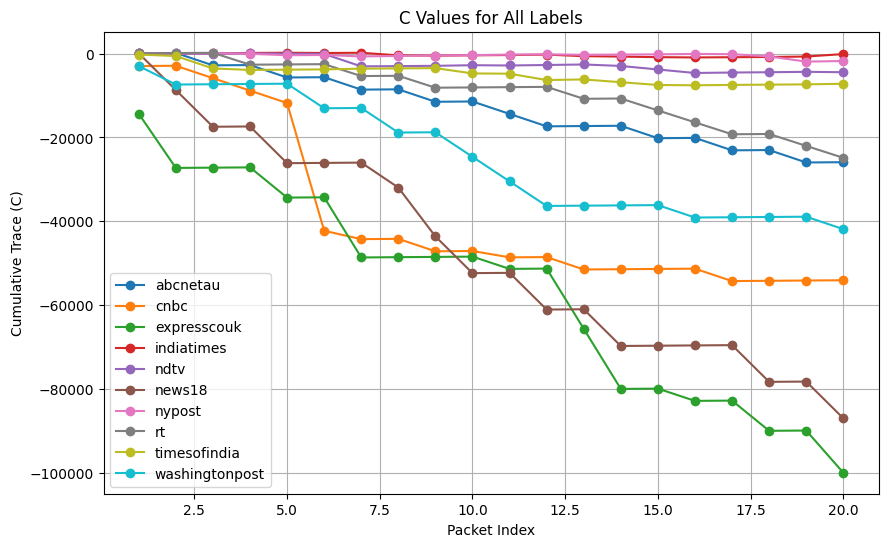

In [26]:
# Initialize the plot
plt.figure(figsize=(10, 6))

# Iterate over each row in result_df
for index, row in result_df.iterrows():
    # Extract label and C_values
    label = row['label']
    C_values = row['C_values']
    
    # Plot the C_values for the current label
    plt.plot(range(1, len(C_values) + 1), C_values, label=label, marker='o')

# Add labels and title
plt.xlabel('Packet Index')
plt.ylabel('Cumulative Trace (C)')
plt.title('C Values for All Labels')
plt.grid(True)
plt.legend()  # Show legend with labels
plt.show()
